# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import math
import json
%matplotlib inline

# Used to ignore some warnings for sns
import warnings 
warnings.filterwarnings('ignore')

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## 1. Inspect the Data

### Inspect portfolio data

In [2]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [3]:
portfolio.shape

(10, 6)

In [4]:
portfolio.describe()

,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


In [5]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 612.0+ bytes


In [6]:
portfolio['channels'].value_counts(), portfolio['offer_type'].value_counts(), portfolio['reward'].value_counts()

(channels
 [web, email, mobile, social]    4
 [web, email, mobile]            3
 [email, mobile, social]         2
 [web, email]                    1
 Name: count, dtype: int64,
 offer_type
 bogo             4
 discount         4
 informational    2
 Name: count, dtype: int64,
 reward
 5     3
 10    2
 0     2
 2     2
 3     1
 Name: count, dtype: int64)

### Inspect profile data

In [7]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [8]:
profile.shape

(17000, 5)

In [9]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [10]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [11]:
# Count null values
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

Gender and income are missing for some customers. We will drop these customers from our analysis in the next section.

In [12]:
profile.shape

(17000, 5)

In [13]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


### Inspect transcript data

In [14]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [15]:
transcript.shape

(306534, 4)

In [16]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [17]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [18]:
transcript['event'].value_counts()

event
transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: count, dtype: int64

## 2. Data Cleaning

### Clean and preprocess portfolio data

In [19]:
# Get dummy variables for channels column
portfolio_channel_dummies = pd.get_dummies(portfolio['channels'].explode(), dtype=int).groupby(level=0).sum()
portfolio_channel_dummies

,email,mobile,social,web
0,1,1,1,0
1,1,1,1,1
2,1,1,0,1
3,1,1,0,1
4,1,0,0,1
5,1,1,1,1
6,1,1,1,1
7,1,1,1,0
8,1,1,1,1
9,1,1,0,1


In [20]:
# Get dummy variables for offer_type column
portfolio_offer_dummies = pd.get_dummies(portfolio['offer_type'], dtype=int)
portfolio_offer_dummies

,bogo,discount,informational
0,1,0,0
1,1,0,0
2,0,0,1
3,1,0,0
4,0,1,0
5,0,1,0
6,0,1,0
7,0,0,1
8,1,0,0
9,0,1,0


In [21]:
clean_portfolio = pd.concat([portfolio, portfolio_channel_dummies, portfolio_offer_dummies], axis=1) # concat dummy variables to portfolio dataframe
clean_portfolio = clean_portfolio.drop(['channels', 'offer_type'], axis=1) # drop channels and offer_type columns
clean_portfolio

,reward,difficulty,duration,id,email,mobile,social,web,bogo,discount,informational
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,4,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0,0,1
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1,0,0
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0,1,0
5,3,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,0,1,0
6,2,10,10,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,0,1,0
7,0,0,3,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0,0,0,1
8,5,5,5,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,0,0
9,2,10,7,2906b810c7d4411798c6938adc9daaa5,1,1,0,1,0,1,0


### Clean and preprocess profile data

In [22]:
# Count null values
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [23]:
# Since the null values for the gender and income columns are the same, we can assume that the same rows have null values for both column and drop them
clean_profile =  profile.dropna()
clean_profile.head()

,gender,age,id,became_member_on,income
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0


### Clean and preprocess transcript data

In [24]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [25]:
transcript['event'].value_counts()

event
transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: count, dtype: int64

In [26]:
# Remove transaction event rows
clean_transcript =  transcript[transcript['event'] != 'transaction']

# Extract the rows that are related to the event
clean_transcript = clean_transcript[clean_transcript['value'].apply(lambda x: True if ('offer id' in x) or ('offer_id' in x) else False)]

# Extract the offer id from value column
clean_transcript['offer_id'] = clean_transcript['value'].apply(lambda x: x['offer id'] if ('offer id' in x) else x['offer_id'])

# Drop the value column
clean_transcript = clean_transcript.drop('value', axis=1)

clean_transcript

,person,event,time,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0
...,...,...,...,...
306497,a6f84f4e976f44508c358cc9aba6d2b3,offer completed,714,2298d6c36e964ae4a3e7e9706d1fb8c2
306506,b895c57e8cd047a8872ce02aa54759d6,offer completed,714,fafdcd668e3743c1bb461111dcafc2a4
306507,8dda575c2a1d44b9ac8e8b07b93d1f8e,offer viewed,714,0b1e1539f2cc45b7b9fa7c272da2e1d7
306509,8431c16f8e1d440880db371a68f82dd0,offer completed,714,fafdcd668e3743c1bb461111dcafc2a4


## 3. Exploratory Data Analysis

### **What is the gender distribution?**

In [27]:
clean_profile['gender'].value_counts().values

array([8484, 6129,  212], dtype=int64)

Text(0, 0.5, 'Count')

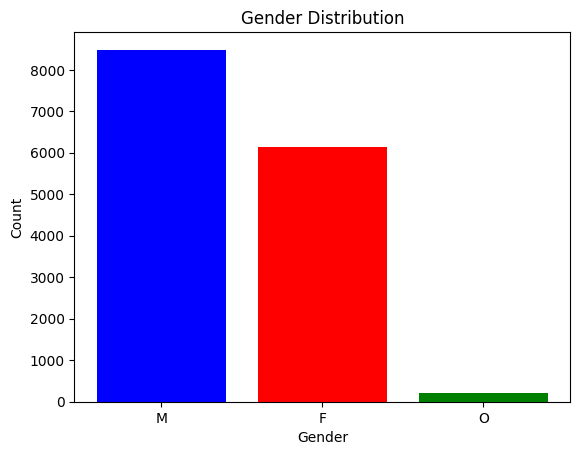

In [28]:
plt.bar(clean_profile['gender'].value_counts().index, clean_profile['gender'].value_counts().values, color=['Blue', 'Red', 'Green'])
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')

There are more male than female and other customers in the study. There are 8484 men, 6129 female and 212 other customers.

### **What is the income distribution between males and females?**

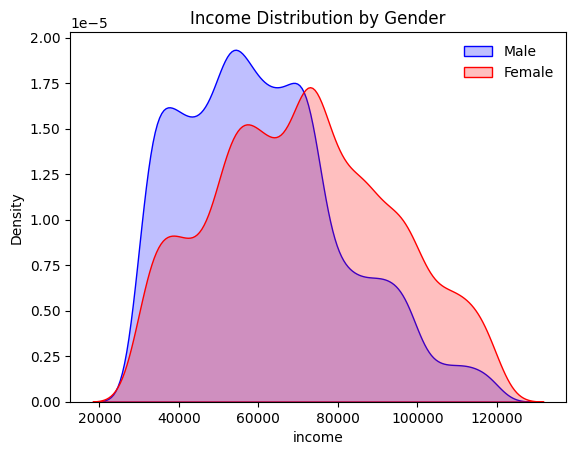

In [29]:
sns.distplot(clean_profile[clean_profile['gender']=='M']['income'],hist=False,color="b", kde_kws={"shade": True});
sns.distplot(clean_profile[clean_profile['gender']=='F']['income'],hist=False,color="r", kde_kws={"shade": True});
plt.title('Income Distribution by Gender')
plt.legend(['Male','Female'],frameon=False)

In [30]:
clean_profile[clean_profile['gender']=='M']['income'].describe(), clean_profile[clean_profile['gender']=='F']['income'].describe()

(count      8484.000000
 mean      61194.601603
 std       20069.517615
 min       30000.000000
 25%       45000.000000
 50%       59000.000000
 75%       73000.000000
 max      120000.000000
 Name: income, dtype: float64,
 count      6129.000000
 mean      71306.412139
 std       22338.353773
 min       30000.000000
 25%       54000.000000
 50%       71000.000000
 75%       88000.000000
 max      120000.000000
 Name: income, dtype: float64)

In [31]:
clean_profile['income'].describe()

count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64

The findings indicate that the income distribution among male and female customers exhibits considerable similarity, with an overall average income close to 65405. However, the average income of male customers seems to lean lower at approximately 61195, whereas the average female income is marginally higher, hovering around 71306.

### **What is the age distribution between males and females?**

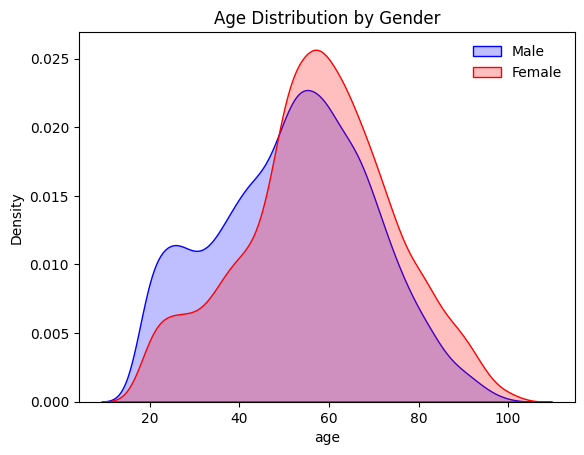

In [32]:
sns.distplot(clean_profile[profile['gender']=='M']['age'],hist=False,color="b", kde_kws={"shade": True})
sns.distplot(clean_profile[profile['gender']=='F']['age'],hist=False,color="r", kde_kws={"shade": True})
plt.title('Age Distribution by Gender')
plt.legend(['Male','Female'],frameon=False)

In [33]:
clean_profile[profile['gender']=='M']['age'].describe(), clean_profile[profile['gender']=='F']['age'].describe()

(count    8484.000000
 mean       52.116690
 std        17.413894
 min        18.000000
 25%        39.000000
 50%        53.000000
 75%        65.000000
 max       100.000000
 Name: age, dtype: float64,
 count    6129.000000
 mean       57.544950
 std        16.883315
 min        18.000000
 25%        48.000000
 50%        58.000000
 75%        69.000000
 max       101.000000
 Name: age, dtype: float64)

In [34]:
clean_profile['age'].describe()

count    14825.000000
mean        54.393524
std         17.383705
min         18.000000
25%         42.000000
50%         55.000000
75%         66.000000
max        101.000000
Name: age, dtype: float64

The study shows that male and female customers are around the same age, with most customers being close to 54 years old. However, male customers are usually a bit younger, with an average around 52 years old, while female customers are a little older, typically around 57.

### **When did customers become members?**

Text(0, 0.5, 'Count')

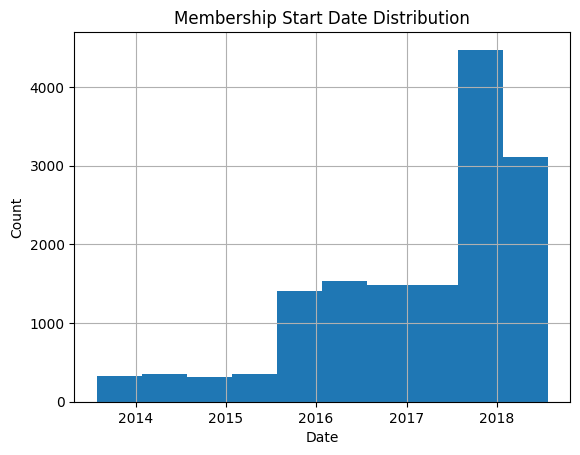

In [35]:
pd.to_datetime(clean_profile['became_member_on'], format='%Y%m%d').hist()
plt.title('Membership Start Date Distribution')
plt.xlabel('Date')
plt.ylabel('Count')

We can see that more more people became members in recent years. The number of members increased from 2013 to 2018, with the most members joining in 2017.

## 4. Create user-item matrix

In [36]:
clean_transcript

,person,event,time,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0
...,...,...,...,...
306497,a6f84f4e976f44508c358cc9aba6d2b3,offer completed,714,2298d6c36e964ae4a3e7e9706d1fb8c2
306506,b895c57e8cd047a8872ce02aa54759d6,offer completed,714,fafdcd668e3743c1bb461111dcafc2a4
306507,8dda575c2a1d44b9ac8e8b07b93d1f8e,offer viewed,714,0b1e1539f2cc45b7b9fa7c272da2e1d7
306509,8431c16f8e1d440880db371a68f82dd0,offer completed,714,fafdcd668e3743c1bb461111dcafc2a4


In [37]:
def create_user_item_matrix(clean_transcript, filename):
    '''
    Return the user item matrix indicating the number of times a user completed an offer.

    Parameters:
    clean_transcript (DataFrame): Cleaned transcript dataframe.
    filename (string): The filename under which the user-item matrix will be saved.

    Returns:
    user_item_matrix (DataFrame): A user-item matrix where the row index represents users,
                                  the columns represent offers,
                                  and the values represent the number of times a user completed an offer.
                                  NaN values mean no offer was given to the user.

    The resulting matrix will be saved as a pickle file.
    '''

    # Create an empty user-item matrix with users as rows, offer as columns, and NaN initial values
    user_item_matrix = clean_transcript.groupby(['person', 'offer_id'])['event'].count().unstack().map(lambda x: np.nan)

    # Delete 'informational' offer types as they don't require completion
    user_item_matrix.drop(list(portfolio[portfolio['offer_type']=='informational']['id']), axis=1, inplace=True)
 
    # Iterate through each offer
    for offer_id in user_item_matrix.columns: 
        print("Processing: ", offer_id)
        num = 0 # Counter for progress updates

        # Iterate through each user
        for person in user_item_matrix.index: 
            num += 1

            # Update progress every 1000 users
            if num % 1000 == 0:
                print("Finished processing ", round(num/user_item_matrix.shape[0]*100), '% of users')
            
            # Get list of events involving current user and offer
            events = list(clean_transcript[(clean_transcript['offer_id']==offer_id) & (clean_transcript['person']==person)]['event']) 
            
            # Only process this user-offer pair if there are at least 3 events
            if len(events) >= 3:
                # Initially set the user-offer count to 0
                user_item_matrix.loc[person, offer_id] = 0 
  
                # Iterate over the events
                for i in range(len(events)-2):
                    # If a 'received' -> 'viewed' -> 'completed' sequence is detected, increment the user-offer count
                    if (events[i] == 'offer received') & (events[i+1] == 'offer viewed') & (events[i+2] == 'offer completed'):
                        user_item_matrix.loc[person, offer_id] += 1
            # Set the user-offer count to 0 if there are events but less than 3
            elif len(events) > 0:
                user_item_matrix.loc[person, offer_id] = 0

    # Write the completed user item matrix to a pickle file
    with open(filename, 'wb') as f:
        pickle.dump(user_item_matrix, f)
        
    return user_item_matrix

In [38]:
# Make a train test split of the user item matrix 70:30
train_size = int(clean_transcript.shape[0]*0.7)
test_size = clean_transcript.shape[0] - train_size
train_size, test_size

(117306, 50275)

In [39]:
train_transcript = clean_transcript.iloc[:train_size, :]
test_transcript = clean_transcript.iloc[train_size:, :]

In [40]:
train_transcript.head()

,person,event,time,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0


In [41]:
test_transcript.head()

,person,event,time,offer_id
209139,ee17ec3543154db188a6afa0d74b7e9f,offer received,504,9b98b8c7a33c4b65b9aebfe6a799e6d9
209140,b148b540df8c4aa5a8a0b79be4fdecbe,offer received,504,5a8bc65990b245e5a138643cd4eb9837
209141,cbd9b4ad54a8422c82004fd4e8d8d746,offer received,504,0b1e1539f2cc45b7b9fa7c272da2e1d7
209142,54ac605ec4354bbfa726012d5236f4a1,offer received,504,9b98b8c7a33c4b65b9aebfe6a799e6d9
209143,0a68034a1858477e8053ca18a05c213c,offer received,504,4d5c57ea9a6940dd891ad53e9dbe8da0


In [42]:
# Took 50 minutes to run
# complete_user_item_matrix = create_user_item_matrix(clean_transcript, 'data/complete_user_item_matrix.pkl')

In [43]:
# Get user item matrix from pickle file instead of running the function again
with open('data/complete_user_item_matrix.pkl', 'rb') as f:
    complete_user_item_matrix = pickle.load(f)

In [44]:
complete_user_item_matrix.shape

(16994, 8)

In [45]:
# Took 35 minutes to run
# train_user_item_matrix = create_user_item_matrix(train_transcript, 'data/train_user_item_matrix.pkl')

In [46]:
# Get user item matrix from pickle file instead of running the function again
with open('data/train_user_item_matrix.pkl', 'rb') as f:
    train_user_item_matrix = pickle.load(f)

In [47]:
train_user_item_matrix.shape

(16955, 8)

In [48]:
# Took 15 minutes to run
# test_user_item_matrix = create_user_item_matrix(test_transcript, 'data/test_user_item_matrix.pkl')

In [49]:
# Get user item matrix from pickle file instead of running the function again
with open('data/test_user_item_matrix.pkl', 'rb') as f:
    test_user_item_matrix = pickle.load(f)

In [50]:
test_user_item_matrix.shape

(15828, 8)

## 5. Apply FunkSVD

In [51]:
def FunkSVD(complete_mat, latent_features=12, learning_rate=0.005, iters=100):
    '''
    This function performs matrix factorization using a basic form of FunkSVD with no regularization
    
    INPUT:
    complete_mat - (numpy array) a matrix with users as rows, offers as columns, and offer completed as values
    latent_features - (int) the number of latent features used
    learning_rate - (float) the learning rate 
    iters - (int) the number of iterations
    
    OUTPUT:
    user_mat - (numpy array) a user by latent feature matrix
    offer_mat - (numpy array) a latent feature by offer matrix
    '''
    
    # Set up required values to be used through the rest of the function
    n_users = complete_mat.shape[0]
    n_offers = complete_mat.shape[1]
    num_complete = np.count_nonzero(~np.isnan(complete_mat))
    
    # Initialize the user and movie matrices with random values
    user_mat = np.random.rand(n_users, latent_features)
    offer_mat = np.random.rand(latent_features, n_offers)
    
    # Initialize sse at 0 for first iteration
    sse_accum = 0
    
    # Keep track of iteration and MSE
    print("Optimizaiton Statistics")
    print("Iterations | Mean Squared Error ")
    
    # For each iteration
    for iteration in range(iters):

        # Update our sse
        old_sse = sse_accum
        sse_accum = 0
        
        # For each user-offer pair
        for i in range(n_users):
            for j in range(n_offers):
                
                # If the rating exists
                if complete_mat[i, j] >= 0:
                    
                    # Compute the error as the actual minus the dot product of the user and offer latent features
                    diff = complete_mat[i, j] - np.dot(user_mat[i, :], offer_mat[:, j])
                    
                    # Keep track of the sum of squared errors for the matrix
                    sse_accum += diff**2
                    
                    # Update the values in each matrix in the direction of the gradient
                    for k in range(latent_features):
                        user_mat[i, k] += learning_rate * (2*diff*offer_mat[k, j])
                        offer_mat[k, j] += learning_rate * (2*diff*user_mat[i, k])

        # Print results
        print("%d \t\t %f" % (iteration+1, sse_accum / num_complete))
        
    return user_mat, offer_mat

In [52]:
train_data_np = np.array(train_user_item_matrix)
train_data_np

array([[nan, nan, nan, ..., nan,  0.,  0.],
       [nan, nan, nan, ..., nan,  0., nan],
       [ 0.,  1., nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan,  0.],
       [nan, nan, nan, ..., nan,  1., nan],
       [ 1., nan,  2., ..., nan, nan,  1.]])

In [53]:
# Funk SVD with 12 latent features, learning rate of 0.005, and 100 iterations (Default Parameters)
user_mat, offer_mat = FunkSVD(train_data_np)

Optimizaiton Statistics
Iterations | Mean Squared Error 


1 		 0.300628
2 		 0.266836
3 		 0.266427
4 		 0.266010
5 		 0.265589
6 		 0.265166
7 		 0.264738
8 		 0.264307
9 		 0.263871
10 		 0.263431
11 		 0.262987
12 		 0.262537
13 		 0.262081
14 		 0.261620
15 		 0.261152
16 		 0.260677
17 		 0.260195
18 		 0.259706
19 		 0.259208
20 		 0.258701
21 		 0.258185
22 		 0.257658
23 		 0.257121
24 		 0.256572
25 		 0.256011
26 		 0.255436
27 		 0.254847
28 		 0.254243
29 		 0.253623
30 		 0.252986
31 		 0.252330
32 		 0.251655
33 		 0.250959
34 		 0.250241
35 		 0.249500
36 		 0.248733
37 		 0.247940
38 		 0.247120
39 		 0.246269
40 		 0.245387
41 		 0.244472
42 		 0.243522
43 		 0.242535
44 		 0.241509
45 		 0.240442
46 		 0.239332
47 		 0.238177
48 		 0.236976
49 		 0.235725
50 		 0.234422
51 		 0.233067
52 		 0.231656
53 		 0.230187
54 		 0.228660
55 		 0.227071
56 		 0.225419
57 		 0.223703
58 		 0.221921
59 		 0.220072
60 		 0.218155
61 		 0.216169
62 		 0.214113
63 		 0.211987
64 		 0.209791
65 		 0.207525
66 		 0.205190
67 		 0.202786
68 	

In [54]:
# Funk SVD with 12 latent features, learning rate of 0.005, and 200 iterations (Higher iterations)
user_mat_200it, offer_mat_200it = FunkSVD(train_data_np, iters=200)

Optimizaiton Statistics
Iterations | Mean Squared Error 
1 		 0.302745
2 		 0.266901
3 		 0.266483
4 		 0.266055
5 		 0.265622
6 		 0.265183
7 		 0.264740
8 		 0.264291
9 		 0.263836
10 		 0.263375
11 		 0.262907
12 		 0.262431
13 		 0.261947
14 		 0.261454
15 		 0.260953
16 		 0.260441
17 		 0.259918
18 		 0.259384
19 		 0.258838
20 		 0.258278
21 		 0.257704
22 		 0.257115
23 		 0.256509
24 		 0.255886
25 		 0.255244
26 		 0.254582
27 		 0.253899
28 		 0.253192
29 		 0.252462
30 		 0.251705
31 		 0.250921
32 		 0.250107
33 		 0.249261
34 		 0.248383
35 		 0.247469
36 		 0.246518
37 		 0.245528
38 		 0.244496
39 		 0.243420
40 		 0.242297
41 		 0.241127
42 		 0.239905
43 		 0.238631
44 		 0.237301
45 		 0.235914
46 		 0.234466
47 		 0.232957
48 		 0.231384
49 		 0.229745
50 		 0.228038
51 		 0.226263
52 		 0.224417
53 		 0.222500
54 		 0.220511
55 		 0.218449
56 		 0.216315
57 		 0.214108
58 		 0.211830
59 		 0.209481
60 		 0.207063
61 		 0.204577
62 		 0.202026
63 		 0.199413
64 		 0

In [55]:
# Funk SVD with 20 latent features, learning rate of 0.005, and 100 iterations (Higher latent features)
user_mat_20lf, offer_mat_20lf = FunkSVD(train_data_np, latent_features=20)

Optimizaiton Statistics
Iterations | Mean Squared Error 
1 		 0.331577
2 		 0.268975
3 		 0.268669
4 		 0.268342
5 		 0.268008
6 		 0.267667
7 		 0.267318
8 		 0.266960
9 		 0.266593
10 		 0.266215
11 		 0.265827
12 		 0.265428
13 		 0.265016
14 		 0.264591
15 		 0.264152
16 		 0.263697
17 		 0.263226
18 		 0.262736
19 		 0.262228
20 		 0.261700
21 		 0.261149
22 		 0.260575
23 		 0.259975
24 		 0.259349
25 		 0.258693
26 		 0.258007
27 		 0.257288
28 		 0.256533
29 		 0.255741
30 		 0.254908
31 		 0.254033
32 		 0.253113
33 		 0.252145
34 		 0.251126
35 		 0.250052
36 		 0.248922
37 		 0.247732
38 		 0.246479
39 		 0.245160
40 		 0.243772
41 		 0.242311
42 		 0.240774
43 		 0.239159
44 		 0.237463
45 		 0.235684
46 		 0.233818
47 		 0.231863
48 		 0.229819
49 		 0.227683
50 		 0.225454
51 		 0.223132
52 		 0.220716
53 		 0.218207
54 		 0.215606
55 		 0.212914
56 		 0.210134
57 		 0.207267
58 		 0.204318
59 		 0.201289
60 		 0.198187
61 		 0.195014
62 		 0.191778
63 		 0.188483
64 		 0

In [56]:
# Funk SVD with 20 latent features, learning rate of 0.005, and 200 iterations (Higher latent features and iterations)
user_mat_20lf_200it, offer_mat_20lf_200it = FunkSVD(train_data_np, latent_features=20, iters=200)

Optimizaiton Statistics
Iterations | Mean Squared Error 
1 		 0.327184
2 		 0.268944
3 		 0.268643
4 		 0.268332
5 		 0.268015
6 		 0.267693
7 		 0.267364
8 		 0.267029
9 		 0.266686
10 		 0.266335
11 		 0.265975
12 		 0.265607
13 		 0.265229
14 		 0.264840
15 		 0.264440
16 		 0.264027
17 		 0.263602
18 		 0.263162
19 		 0.262707
20 		 0.262237
21 		 0.261748
22 		 0.261241
23 		 0.260714
24 		 0.260166
25 		 0.259594
26 		 0.258998
27 		 0.258376
28 		 0.257725
29 		 0.257044
30 		 0.256331
31 		 0.255584
32 		 0.254800
33 		 0.253977
34 		 0.253113
35 		 0.252205
36 		 0.251251
37 		 0.250247
38 		 0.249190
39 		 0.248079
40 		 0.246910
41 		 0.245680
42 		 0.244387
43 		 0.243026
44 		 0.241595
45 		 0.240092
46 		 0.238514
47 		 0.236857
48 		 0.235120
49 		 0.233299
50 		 0.231394
51 		 0.229402
52 		 0.227322
53 		 0.225153
54 		 0.222893
55 		 0.220543
56 		 0.218104
57 		 0.215574
58 		 0.212956
59 		 0.210252
60 		 0.207462
61 		 0.204591
62 		 0.201642
63 		 0.198617
64 		 0

## 6. Predict and Validate Results

In [57]:
def predict_offer(user_matrix, offer_matrix, user_id, offer_id):
    '''
    Predicts a user's reaction to an offer using FunkSVD.

    Parameters:
    user_matrix (ndarray): User by latent factor matrix.
    offer_matrix (ndarray): Latent factor by offer matrix.
    user_id (string): The user_id from the user-item matrix.
    offer_id (string): The offer_id from the user-item matrix.

    Returns:
    pred (float): The predicted reaction for the user_id-offer_id pair according to FunkSVD. Returns None if prediction is not possible due to the user or offer not being in the training set.
    '''
    try:
        # Create a series of user IDs and offer IDs that match the ordering in the original data
        user_ids_series = np.array(complete_user_item_matrix.index)
        offer_ids_series = np.array(complete_user_item_matrix.columns)

        # Obtain the row index in user_matrix corresponding to the given user_id
        user_row = np.where(user_ids_series == user_id)[0][0]

        # Obtain the column index in offer_matrix corresponding to the given offer_id
        offer_col = np.where(offer_ids_series == offer_id)[0][0]

        # Take the dot product of the user's row in user_matrix with the offer's column in offer_matrix to generate the prediction
        pred = np.dot(user_matrix[user_row, :], offer_matrix[:, offer_col])
        
        return pred
    
    except:
        # Return None if prediction not possible (e.g., user or offer not in training set)
        return None

In [58]:
def validate(test_df, user_mat, offer_mat):
    '''
    Compute the Mean Squared Error (MSE) of the predicted user's reaction to offers.
    
    Parameters:
    test_df (DataFrame): DataFrame that contains the actual user's reaction to offers that we want to test our predictions against.
    user_mat (array): User by latent factor matrix.
    offer_mat (array): Latent factor by offer matrix.

    Output:
    print statement: The MSE of the user's reaction for the given test dataset and latent features.
    '''
    
    # Count the total number of non-missing values in the test dataset
    num_complete = np.count_nonzero(~np.isnan(test_df))

    # Initialize a variable to hold the sum of squared errors (SSE)
    sse_accum = 0

    # Iterate over each user
    for user_id in test_df.index:
        # Iterate over each offer for the current user
        for offer_id in test_df.columns:
            # If the user's reaction to the offer is not missing, then proceed
            if ~np.isnan(test_df.loc[user_id, offer_id]):
                # Predict the user's reaction to the offer
                predict_value = predict_offer(user_mat, offer_mat, user_id, offer_id)
                # If a prediction is made (i.e prediction is not None)
                if predict_value != None:
                    # Compute the prediction error by subtracting the predicted value from the actual value
                    diff = test_df.loc[user_id, offer_id] - predict_value
                    # Add the squared prediction error to the total SSE
                    sse_accum += diff**2
    
    # Print the average of SSE, which is the Mean Squared Error (MSE)
    print(sse_accum / num_complete)

In [59]:
# Evaluation for default parameters
validate(test_user_item_matrix, user_mat, offer_mat)

0.3622473676407589


In [60]:
# Evaluation for higher iterations
validate(test_user_item_matrix, user_mat_200it, offer_mat_200it) # Best result

0.4780780023463941


In [61]:
# Evaluation for higher latent features
validate(test_user_item_matrix, user_mat_20lf, offer_mat_20lf)

0.3967874286376631


In [62]:
# Evaluation for higher latent features and iterations
validate(test_user_item_matrix, user_mat_20lf_200it, offer_mat_20lf_200it)

0.4803512458747647


The best results are obtained with lower iterations and lower latent features when running validation.  The best obtained with the default paremeters in this case with a low MSE.

## 7. Recommendations for Starbucks Offers

In [63]:
def best_sale_offer(user_item_matrix):
    '''
    Calculate and print the total gain for each offer.

    Parameters:
    user_item_matrix (DataFrame): Matrix with users as rows and offers as columns. 
                                  Values indicate the number of times a user completed an offer.
    
    Returns
    offer_value (DataFrame): A DataFrame with each offer and its corresponding total gain, sorted by gain in descending order.
    '''
    
    # Initialize an empty list to hold the total gain for each offer
    offer_gain = []
    
    # Iterate over each offer column in the user_item_matrix
    for offer_id in user_item_matrix.columns:
        # Gain is calculated as the sum of transaction values where the event is 'transaction' and the person has completed the offer at least once
        offer_gain.append([offer_id, transcript[(transcript['person'].isin(list(user_item_matrix[user_item_matrix[offer_id]>=1].index)))&(transcript['event']=='transaction')]['value'].apply(lambda x: x['amount']).sum()])

    # Convert offer_gain list to a DataFrame
    offer_value = pd.DataFrame(offer_gain, columns=['offer_id', 'gain'])
    
    # Convert gain values to numeric type
    offer_value['gain'] = pd.to_numeric(offer_value['gain'])
    
    # Sort the DataFrame by gain in descending order
    offer_value.sort_values(by='gain', ascending=False, inplace=True)
    
    # Print the sorted DataFrame
    print(offer_value)
    
    return offer_value

In [64]:
def recommend_offer(user_id, user_mat, offer_mat):
    ''' 
    Recommend offers to a user based on their predicted reactions.

    Parameters:
    user_id (string): The user_id for whom we want to generate recommendations.
    user_mat (array): Users by latent factors matrix.
    offer_mat (array): Latent factors by offer matrix.

    Outputs:
    Prints out a list of recommended offer ids for the given user, sorted by predicted reaction value.
    If user_id is not in the database, prints out a list of top sale offer recommendations.
    '''    

    # Initialize a dictionary to store the predicted reaction for each offer for the given user
    recommend = {}
    
    # Iterate through each offer in the training matrix
    for offer_id in train_user_item_matrix.columns:
        # Predict the user's reaction to the offer
        pred_val = predict_offer(user_mat, offer_mat, user_id, offer_id)
        
        # If a prediction was made, add it to the recommend dictionary, where the offer_id is the key and the predicted value is the value
        if pred_val != None:
            recommend[offer_id] = pred_val
        # If no prediction was made (i.e., if the user is not in the database), stop iterating through offers
        else:
            break
    
    # If no prediction was made for any offer,
    if pred_val == None:
        # Inform the user that since they're not in our database, we're giving them our best sale offer recommendations.
        print("Because this user is not in our database, we are offering the top sale offer recommendation.")
        
        # Get the top sale offers
        top_offer = best_sale_offer(complete_user_item_matrix)
        
        # Print each recommended offer (top sale offers)
        for offer_id in top_offer['offer_id']:
            print("offer id: ", offer_id)
    # If predictions were made for offers,
    else:
        # Inform the user that we're giving them recommendations based on their predicted reactions.
        print("Recommend offer for user ", user_id)
        
        # Print each recommended offer and its predicted value sorted in descending order of the predicted value
        for offer_id, pred_val in sorted(recommend.items(), key=lambda kv:(kv[1], kv[0]), reverse=True):
            print("offer id: ", offer_id, " predicted value: ", round(pred_val,2))

In [65]:
clean_profile.head()

,gender,age,id,became_member_on,income
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0


In [66]:
# Recommend offer for the first user using default parameters
recommend_offer('0610b486422d4921ae7d2bf64640c50b', user_mat, offer_mat)

Recommend offer for user  0610b486422d4921ae7d2bf64640c50b
offer id:  f19421c1d4aa40978ebb69ca19b0e20d  predicted value:  1.59
offer id:  fafdcd668e3743c1bb461111dcafc2a4  predicted value:  1.28
offer id:  2298d6c36e964ae4a3e7e9706d1fb8c2  predicted value:  0.98
offer id:  ae264e3637204a6fb9bb56bc8210ddfd  predicted value:  0.98
offer id:  4d5c57ea9a6940dd891ad53e9dbe8da0  predicted value:  0.8
offer id:  9b98b8c7a33c4b65b9aebfe6a799e6d9  predicted value:  0.41
offer id:  0b1e1539f2cc45b7b9fa7c272da2e1d7  predicted value:  0.17
offer id:  2906b810c7d4411798c6938adc9daaa5  predicted value:  0.12


In [67]:
# Reccomend offer for the first user using higher iterations
recommend_offer('0610b486422d4921ae7d2bf64640c50b', user_mat_200it, offer_mat_200it)

Recommend offer for user  0610b486422d4921ae7d2bf64640c50b
offer id:  f19421c1d4aa40978ebb69ca19b0e20d  predicted value:  1.43
offer id:  4d5c57ea9a6940dd891ad53e9dbe8da0  predicted value:  1.02
offer id:  2298d6c36e964ae4a3e7e9706d1fb8c2  predicted value:  1.01
offer id:  fafdcd668e3743c1bb461111dcafc2a4  predicted value:  0.98
offer id:  2906b810c7d4411798c6938adc9daaa5  predicted value:  0.82
offer id:  0b1e1539f2cc45b7b9fa7c272da2e1d7  predicted value:  0.5
offer id:  ae264e3637204a6fb9bb56bc8210ddfd  predicted value:  0.17
offer id:  9b98b8c7a33c4b65b9aebfe6a799e6d9  predicted value:  -0.08


In [68]:
# Recommend offer for the first user using higher latent features
recommend_offer('0610b486422d4921ae7d2bf64640c50b', user_mat_20lf, offer_mat_20lf)

Recommend offer for user  0610b486422d4921ae7d2bf64640c50b
offer id:  2298d6c36e964ae4a3e7e9706d1fb8c2  predicted value:  1.33
offer id:  fafdcd668e3743c1bb461111dcafc2a4  predicted value:  0.87
offer id:  4d5c57ea9a6940dd891ad53e9dbe8da0  predicted value:  0.67
offer id:  f19421c1d4aa40978ebb69ca19b0e20d  predicted value:  0.44
offer id:  9b98b8c7a33c4b65b9aebfe6a799e6d9  predicted value:  0.43
offer id:  ae264e3637204a6fb9bb56bc8210ddfd  predicted value:  0.17
offer id:  0b1e1539f2cc45b7b9fa7c272da2e1d7  predicted value:  0.1
offer id:  2906b810c7d4411798c6938adc9daaa5  predicted value:  0.09


In [69]:
# Recommend offer for the first user using higher latent features and iterations
recommend_offer('0610b486422d4921ae7d2bf64640c50b', user_mat_20lf_200it, offer_mat_20lf_200it)

Recommend offer for user  0610b486422d4921ae7d2bf64640c50b
offer id:  f19421c1d4aa40978ebb69ca19b0e20d  predicted value:  2.11
offer id:  fafdcd668e3743c1bb461111dcafc2a4  predicted value:  1.1
offer id:  2298d6c36e964ae4a3e7e9706d1fb8c2  predicted value:  1.04
offer id:  4d5c57ea9a6940dd891ad53e9dbe8da0  predicted value:  0.91
offer id:  9b98b8c7a33c4b65b9aebfe6a799e6d9  predicted value:  0.75
offer id:  2906b810c7d4411798c6938adc9daaa5  predicted value:  0.66
offer id:  ae264e3637204a6fb9bb56bc8210ddfd  predicted value:  0.56
offer id:  0b1e1539f2cc45b7b9fa7c272da2e1d7  predicted value:  0.18


In [70]:
# Reccomend offer for a new user using default parameters
recommend_offer('new_user', user_mat, offer_mat)

Because this user is not in our database, we are offering the top sale offer recommendation.


                           offer_id       gain
7  fafdcd668e3743c1bb461111dcafc2a4  596220.84
1  2298d6c36e964ae4a3e7e9706d1fb8c2  538027.98
6  f19421c1d4aa40978ebb69ca19b0e20d  480555.03
3  4d5c57ea9a6940dd891ad53e9dbe8da0  441918.93
5  ae264e3637204a6fb9bb56bc8210ddfd  423683.27
2  2906b810c7d4411798c6938adc9daaa5  305568.42
4  9b98b8c7a33c4b65b9aebfe6a799e6d9  304361.77
0  0b1e1539f2cc45b7b9fa7c272da2e1d7  218905.94
offer id:  fafdcd668e3743c1bb461111dcafc2a4
offer id:  2298d6c36e964ae4a3e7e9706d1fb8c2
offer id:  f19421c1d4aa40978ebb69ca19b0e20d
offer id:  4d5c57ea9a6940dd891ad53e9dbe8da0
offer id:  ae264e3637204a6fb9bb56bc8210ddfd
offer id:  2906b810c7d4411798c6938adc9daaa5
offer id:  9b98b8c7a33c4b65b9aebfe6a799e6d9
offer id:  0b1e1539f2cc45b7b9fa7c272da2e1d7


We can see that a new user gets the top sales offers since there is nothing to recommend yet.